# Initial Attempt:
Uses Shape, Statistics, Histogram, and Regional features only

In [1]:
import pandas as pd
import numpy as np

In [2]:
features_regional = np.load('features_regional.npy')
features_shape = np.load('features_shape.npy')
features_stats = np.load('features_stats.npy')
features_histogram = np.load('features_histogram.npy')

features = np.concatenate((features_regional, features_shape,
                           features_stats,features_histogram),axis=1)
features.shape

(1472, 93)

In [3]:
labels = pd.read_csv('../data/ATR_GT_Training.csv', header=None)
X = features[:1005]
y = labels.iloc[:1005, 1]
y_bin = (y!=0).astype(int)

In [4]:
from sklearn import preprocessing
X_scaled = preprocessing.scale(X)

### SVM, LR, AdaBoost, 3NN, MLP, and Voting Classifier Testing

In [5]:
classifiers=[]

In [6]:
from sklearn import svm
classifiers.append(['SVM', svm.SVC()])

In [7]:
from sklearn.linear_model import LogisticRegression
classifiers.append(['Logistic Regression', LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')])

In [8]:
from sklearn.ensemble import AdaBoostClassifier
classifiers.append(['AdaBoost', AdaBoostClassifier(n_estimators=100)])

In [9]:
from sklearn.neighbors import KNeighborsClassifier
classifiers.append(['3NN', KNeighborsClassifier(n_neighbors=3)])

In [10]:
from sklearn.neural_network import MLPClassifier
classifiers.append(['MLP', MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)])

### Evaluate using 5-Fold Cross Validation

In [11]:
from sklearn.model_selection import cross_val_score
def cross_validate(classifier,X,y,name,cv_=5):
    scores = cross_val_score(classifier, X, y, cv=cv_)
    print(name)
    print('Accuracy: ', str(scores.mean()))
    print('StDev: ', str(scores.std()))
    print()

In [12]:
import warnings
warnings.filterwarnings('ignore')
for classifier_name, classifier in classifiers:
    cross_validate(classifier,X_scaled,y_bin,classifier_name)

SVM
Accuracy:  0.7910447761194029
StDev:  0.031622385237951633

Logistic Regression
Accuracy:  0.7820895522388059
StDev:  0.03466915699539174

AdaBoost
Accuracy:  0.8417910447761194
StDev:  0.0414341548530488

3NN
Accuracy:  0.8189054726368159
StDev:  0.039875552058734096

MLP
Accuracy:  0.8238805970149252
StDev:  0.030278853840204865



### Use the previous classifiers as estimators in a voting classifier

In [13]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=classifiers, voting='hard')
cross_validate(vclf,X_scaled,y_bin,'Voting')

Voting
Accuracy:  0.8447761194029851
StDev:  0.0385884963774434



### Use the voting classifier to generate predictions on the blind testing set

In [14]:
vclf = vclf.fit(X, y)
pred = vclf.predict(features[1005:])
filenames = labels.iloc[1005:, 0]
pred_df = {'file': filenames, 'prediction': pred}
pd.DataFrame(pred_df).to_csv('votingpredictions.csv')

### Preliminary Results
Results from professor on testing predictions:<br>
Recall Rate:0.20325 25/123<br>
Precision Rate:0.98837 340/344<br>
Saline Recall Rate:0 0/41<br>
Rubber Recall Rate:0.25 11/44<br>
Clay Recall Rate:0.36842 14/38

# Refined Approach: Random Forest Testing
Add texture features and use Random Forest

In [23]:
features_texture = np.load('features_texture.npy')
features = np.concatenate((features_regional, features_shape,
                           features_stats,features_histogram,np.nan_to_num(features_texture)),axis=1)
X = features[:1005]
features.shape

(1472, 327)

In [16]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score
def evaluate(X, y, clf, name):
    kf = KFold(n_splits=5)
    r,r1,r2,r3, fa, acc = [],[],[],[],[],[]

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        predict = clf.fit(X_train, y_train!=0).predict(X_test)

        acc.append(accuracy_score(y_test!=0, predict))
        r.append(recall_score(y_test!=0,   predict))
        r1.append(recall_score(y_test==1,  predict))
        r2.append(recall_score(y_test==2,  predict))
        r3.append(recall_score(y_test==3,  predict))
        fa.append(1-accuracy_score(1-(y_test!=0), 1-predict))
    
    print(name)
    print('accuracy      ',np.mean(acc))
    print('recall        ',np.mean(r))
    print('false alarm   ',np.mean(fa))
    print('saline recall ',np.mean(r1))
    print('rubber recall ',np.mean(r2))
    print('clay recall   ',np.mean(r3))
    print('\n')
    return np.mean(r)

### Test the random forest classifier with different number of estimators

Random Forest
accuracy       0.8129353233830845
recall         0.6100856228028171
false alarm    0.18706467661691542
saline recall  0.5698095238095238
rubber recall  0.5968688781507117
clay recall    0.6835805860805861


Random Forest
accuracy       0.8228855721393036
recall         0.5225329369450465
false alarm    0.17711442786069653
saline recall  0.4100714285714286
rubber recall  0.6163053415175657
clay recall    0.544551282051282


Random Forest
accuracy       0.8437810945273633
recall         0.5931532214444484
false alarm    0.15621890547263687
saline recall  0.43809523809523815
rubber recall  0.627015584867877
clay recall    0.7678021978021978


Random Forest
accuracy       0.8606965174129353
recall         0.6661915421749127
false alarm    0.13930348258706468
saline recall  0.5514523809523809
rubber recall  0.7125233990683906
clay recall    0.7774175824175824


Random Forest
accuracy       0.8587064676616916
recall         0.6535163104078998
false alarm    0.14129353233830846


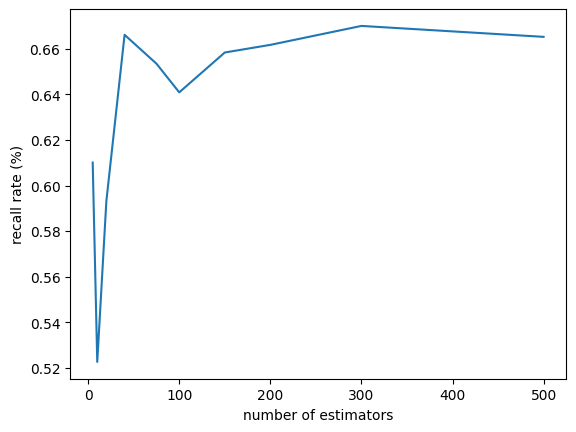

In [17]:
estimators = [5, 10, 20, 40, 75, 100, 150, 200, 300, 500]
from sklearn.ensemble import RandomForestClassifier
recalls = []
for n_estimators in estimators:
    recalls.append(evaluate(X, y, RandomForestClassifier(n_estimators=n_estimators, max_depth=None, min_samples_split=2), 'Random Forest'))

import matplotlib.pyplot as plt
plt.plot(estimators,recalls)
plt.xlabel('number of estimators')
plt.ylabel('recall rate (%)')
plt.show()

### Test the random forest classifier with different numbers of max features

Random Forest
accuracy       0.7641791044776118
recall         0.2864792564504749
false alarm    0.23582089552238808
saline recall  0.15930952380952382
rubber recall  0.38648404510034384
clay recall    0.32172466422466417


Random Forest
accuracy       0.7890547263681592
recall         0.36696158902746684
false alarm    0.21094527363184082
saline recall  0.23149999999999998
rubber recall  0.4221942884506551
clay recall    0.47514652014652015


Random Forest
accuracy       0.8139303482587064
recall         0.4900593285200469
false alarm    0.18606965174129353
saline recall  0.3580952380952381
rubber recall  0.5435168255626659
clay recall    0.6116025641025641


Random Forest
accuracy       0.8437810945273633
recall         0.5936247926547469
false alarm    0.15621890547263678
saline recall  0.44938095238095244
rubber recall  0.6526381089199426
clay recall    0.7383760683760684


Random Forest
accuracy       0.8616915422885573
recall         0.6789542523472808
false alarm    0.1383084577

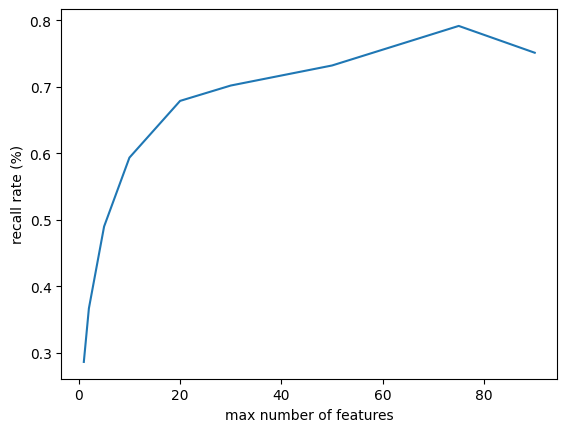

In [18]:
max_features = [1, 2, 5, 10, 20, 30, 50, 75, 90]
from sklearn.ensemble import RandomForestClassifier
recalls = []
for n_max_features in max_features:
    recalls.append(evaluate(X, y, RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, max_features=n_max_features), 'Random Forest'))

import matplotlib.pyplot as plt
plt.plot(max_features,recalls)
plt.xlabel('max number of features')
plt.ylabel('recall rate (%)')
plt.show()

### Generate predictions on the blind testing set

In [19]:
rfc = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=2, max_features=100)
evaluate(X, y, rfc, 'Random Forest')

Random Forest
accuracy       0.8597014925373134
recall         0.7652664481680578
false alarm    0.1402985074626866
saline recall  0.7465238095238096
rubber recall  0.697922380392669
clay recall    0.8637881562881562




0.7652664481680578

In [20]:
rfc = rfc.fit(X, y)
pred = rfc.predict(features[1005:])
filenames = labels.iloc[1005:, 0]
pred_df = {'file': filenames, 'prediction': pred}
pd.DataFrame(pred_df).to_csv('randomforestpredictions.csv')

### Results
Results from professor on testing predictions:<br>
Recall Rate:0.72358 89/123<br>
Precision Rate:0.90407 311/344<br>
Saline Recall Rate:0.7561 31/41<br>
Rubber Recall Rate:0.61364 27/44<br>
Clay Recall Rate:0.81579 31/38